## 0. Setup and Imports

ეს სექცია პასუხისმგებელია გარემოს მომზადებაზე: საჭირო ბიბლიოთეკების იმპორტი და ვიზუალიზაციის სტილის დაყენება.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! pip install kaggle

! mkdir ~/.kaggle

!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c walmart-recruiting-store-sales-forecasting

! unzip walmart-recruiting-store-sales-forecasting

!pip install -q wandb

Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 548MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [2]:
from zipfile import ZipFile

with ZipFile('/content/features.csv.zip') as f:
    f.extractall(path='/content/')

with ZipFile('/content/sampleSubmission.csv.zip') as f:
    f.extractall(path='/content/')

with ZipFile('/content/test.csv.zip') as f:
    f.extractall(path='/content/')

with ZipFile('/content/train.csv.zip') as f:
    f.extractall(path='/content/')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plot style for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

print("Setup Complete!")

Setup Complete!


## 1. Data Loading and Initial Overview

ამ ეტაპზე ვტვირთავთ ყველა საჭირო მონაცემთა ფაილს და ვაერთიანებთ ერთიან DataFrame-ში. შემდეგ ვამოწმებთ მონაცემთა ტიპებს და გამოტოვებულ მნიშვნელობებს.

In [4]:
try:
    stores = pd.read_csv('/content/stores.csv')
    features = pd.read_csv('/content/features.csv')
    train = pd.read_csv('/content/train.csv')
    test = pd.read_csv('/content/test.csv')
except FileNotFoundError:
    print("Data files not found. Make sure they are in '/content/' folder relative to the notebook.")

# Merge dataframes
df_train = pd.merge(train, stores, on='Store', how='left')
df_train = pd.merge(df_train, features, on=['Store', 'Date', 'IsHoliday'], how='left')

# Convert Date column to datetime objects
df_train['Date'] = pd.to_datetime(df_train['Date'])

print("Train Data Shape:", df_train.shape)
df_train.head()

Train Data Shape: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [5]:
print("Data Information:")
df_train.info()

print("\nMissing Values:")
df_train.isnull().sum()

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15 

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Type,0
Size,0
Temperature,0
Fuel_Price,0
MarkDown1,270889


### დაკვირვება:
- `Date` სვეტი წარმატებით გადაკეთდა `datetime` ტიპში.
- 4 სვეტს (`MarkDown1` - `MarkDown5`) აქვს დიდი რაოდენობით გამოტოვებული მნიშვნელობა. ეს ლოგიკურია, რადგან NaN აქ, სავარაუდოდ, ნიშნავს, რომ იმ კვირაში ფასდაკლება არ იყო. მოდელირებისას ამ ცარიელ მნიშვნელობებს შევავსებთ 0-ით.
- `CPI` და `Unemployment` სვეტებსაც აქვს მცირე რაოდენობით გამოტოვებული მნიშვნელობა, რომელთა შევსებაც დაგვჭირდება (მაგალითად, წინა მნიშვნელობით ან საშუალოთი).

## 2. Exploratory Data Analysis (EDA)

### 2.1. Overall Sales Trend & Seasonality
ვნახოთ, როგორ იცვლება ჯამური გაყიდვები დროთა განმავლობაში.

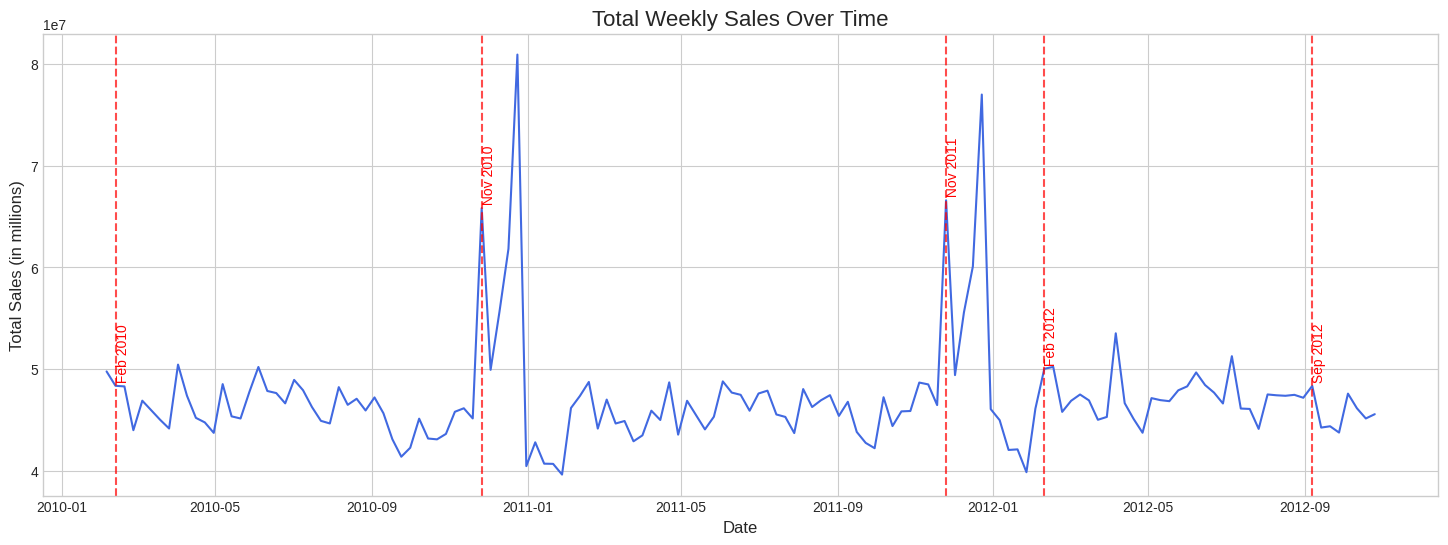

In [6]:
total_sales = df_train.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(18, 6))
sns.lineplot(data=total_sales, x='Date', y='Weekly_Sales', color='royalblue')

# Annotate major holiday peaks
holiday_dates = df_train[df_train['IsHoliday']].groupby('Date').sum().index
peaks = total_sales.loc[total_sales['Date'].isin(holiday_dates)].sort_values(by='Weekly_Sales', ascending=False).head(5)
for i, row in peaks.iterrows():
    plt.axvline(x=row['Date'], color='red', linestyle='--', alpha=0.7)
    plt.text(row['Date'], row['Weekly_Sales'], f' {row["Date"].strftime("%b %Y")}', rotation=90, verticalalignment='bottom', color='red')

plt.title('Total Weekly Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales (in millions)', fontsize=12)
plt.show()

### დასკვნა:
1.  **აშკარა წლიური სეზონურობა:** გაყიდვებს აქვს მკვეთრად გამოხატული პიკები ყოველი წლის ბოლოს (ნოემბერი-დეკემბერი), რაც მადლიერების დღეს და შობას უკავშირდება.
2.  **დღესასწაულების გავლენა:** წითელი ხაზებით აღნიშნული სადღესასწაულო კვირები ემთხვევა გაყიდვების ყველაზე დიდ პიკებს. ეს ადასტურებს, რომ შეფასების მეტრიკის (WMAE) აქცენტი დღესასწაულებზე გამართლებულია და მოდელმა ეს პიკები ზუსტად უნდა იწინასწარმეტყველოს.
3.  **ტრენდი:** საერთო ჯამში, ძლიერი აღმავალი ან დაღმავალი ტრენდი არ ჩანს.

### 2.2. Granular Analysis (by Store and Department)
შევადაროთ გაყიდვები სხვადასხვა მაღაზიის, მაღაზიის ტიპისა და დეპარტამენტის მიხედვით.

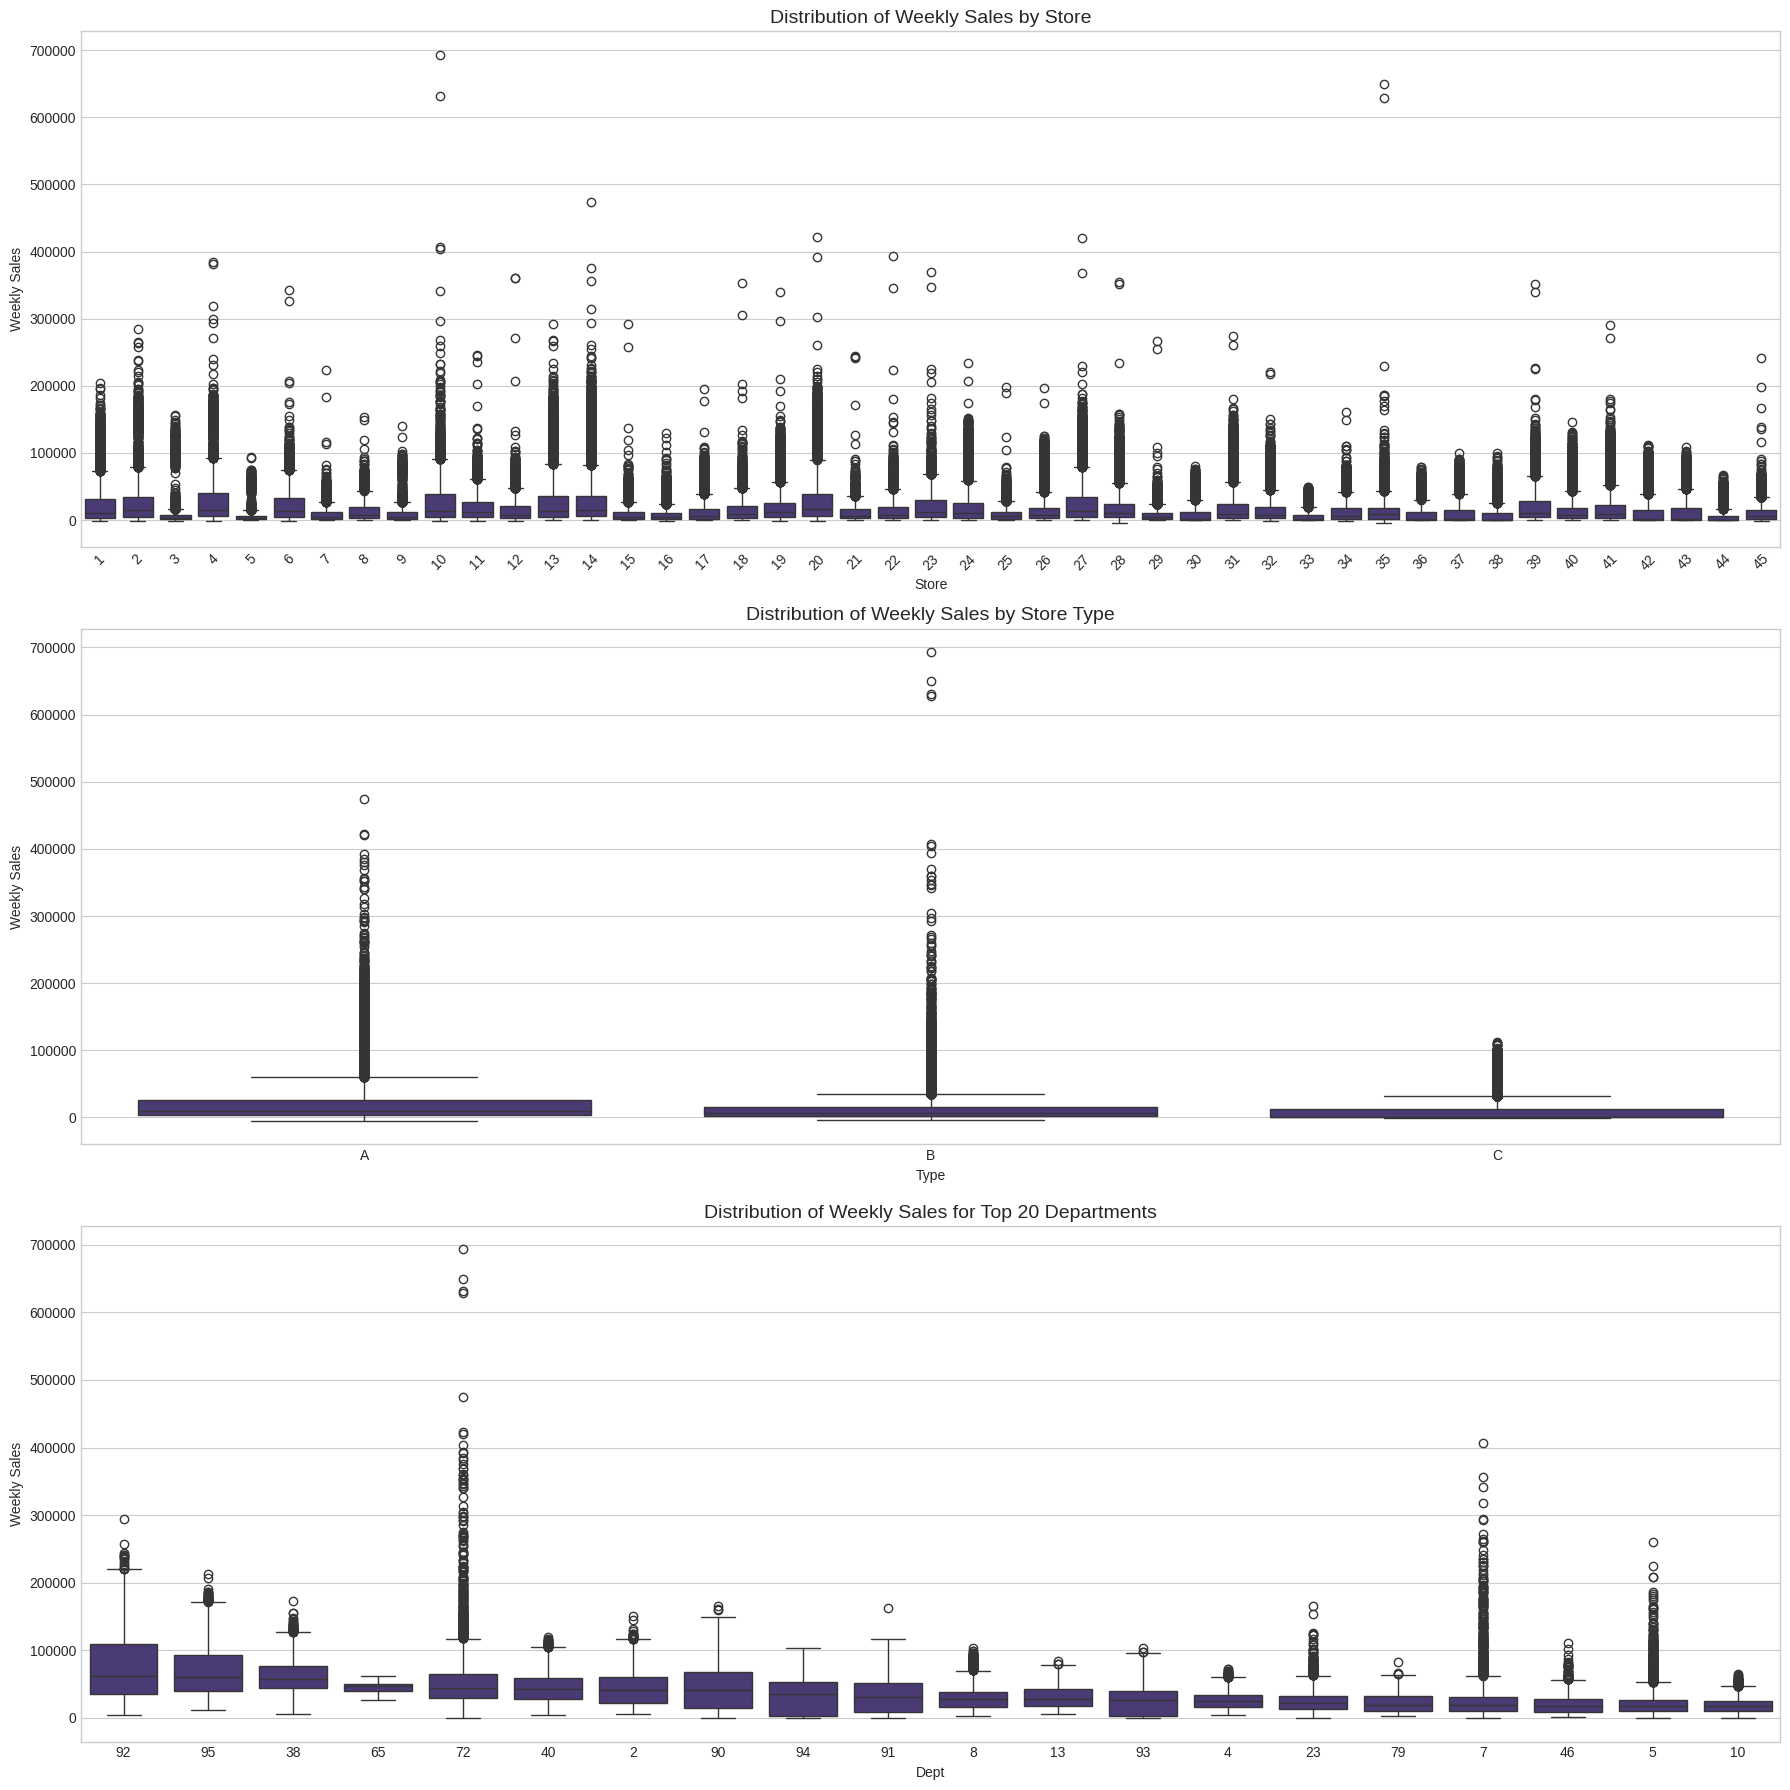

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(18, 18))

# Sales by Store
sns.boxplot(data=df_train, x='Store', y='Weekly_Sales', ax=axs[0])
axs[0].set_title('Distribution of Weekly Sales by Store', fontsize=14)
axs[0].set_ylabel('Weekly Sales')
axs[0].tick_params(axis='x', rotation=45)

# Sales by Store Type
sns.boxplot(data=df_train, x='Type', y='Weekly_Sales', ax=axs[1], order=['A', 'B', 'C'])
axs[1].set_title('Distribution of Weekly Sales by Store Type', fontsize=14)
axs[1].set_ylabel('Weekly Sales')

# Sales by Department (Top 20 Departments by median sales)
top_depts = df_train.groupby('Dept')['Weekly_Sales'].median().nlargest(20).index
sns.boxplot(data=df_train[df_train['Dept'].isin(top_depts)], x='Dept', y='Weekly_Sales', ax=axs[2], order=top_depts)
axs[2].set_title('Distribution of Weekly Sales for Top 20 Departments', fontsize=14)
axs[2].set_ylabel('Weekly Sales')

plt.tight_layout()

### დასკვნა:
1.  **მაღაზიებს შორის განსხვავება:** სხვადასხვა მაღაზიას გაყიდვების სრულიად განსხვავებული მოცულობა და განაწილება აქვს. ზოგიერთი მაღაზია (მაგ. 4, 14, 20) ბევრად უფრო მაღალშემოსავლიანია. **მნიშვნელოვანია:** `Store` უნდა იყოს გამოყენებული როგორც კატეგორიული ფიჩერი მოდელში.
2.  **მაღაზიის ტიპი:** `A` ტიპის მაღაზიებს მნიშვნელოვნად მაღალი გაყიდვები აქვთ, ვიდრე `B` და `C` ტიპის მაღაზიებს. `Type` ასევე მნიშვნელოვანი ფიჩერია.
3.  **დეპარტამენტებს შორის განსხვავება:** დეპარტამენტებს შორის კიდევ უფრო დიდი ვარიაციაა. ზოგიერთ დეპარტამენტს (მაგ. 92, 95) აქვს ძალიან მაღალი მედიანური გაყიდვები. `Dept` იქნება ერთ-ერთი ყველაზე კრიტიკული ფიჩერი პროგნოზისთვის. გაითვალისწინეთ, რომ `Weekly_Sales` ზოგ დეპარტამენტში უარყოფითია, რაც, სავარაუდოდ, დაბრუნებებს ნიშნავს.

### 2.3. Impact of Holidays
უფრო ღრმად გამოვიკვლიოთ სადღესასწაულო კვირების გავლენა.

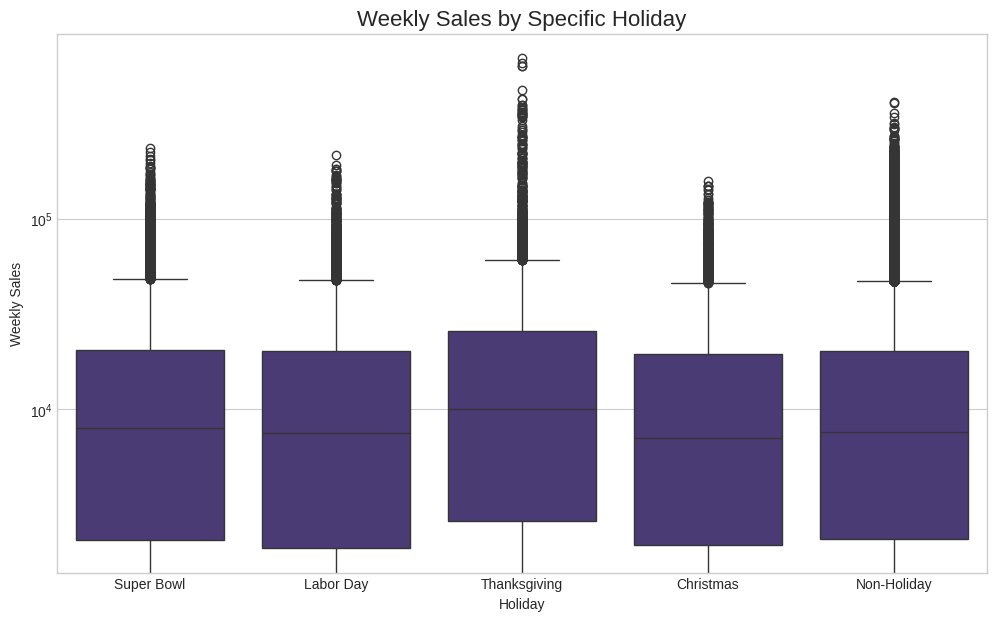

In [8]:
# Identify specific holidays based on dates
def get_holiday_name(date):
    d = date.strftime('%m-%d')
    if '02-1' in d[:4]: return 'Super Bowl'
    if '09-0' in d[:4] or '09-10' in d[:4]: return 'Labor Day'
    if '11-2' in d[:4]: return 'Thanksgiving'
    if '12-2' in d[:4] or '12-3' in d[:4]: return 'Christmas'
    return 'Non-Holiday'

holiday_df = df_train.copy()
holiday_df['HolidayName'] = holiday_df[holiday_df['IsHoliday']]['Date'].apply(get_holiday_name)
holiday_df['HolidayName'] = holiday_df['HolidayName'].fillna('Non-Holiday')

plt.figure(figsize=(12, 7))
sns.boxplot(data=holiday_df, x='HolidayName', y='Weekly_Sales', order=['Super Bowl', 'Labor Day', 'Thanksgiving', 'Christmas', 'Non-Holiday'])
plt.title('Weekly Sales by Specific Holiday', fontsize=16)
plt.ylabel('Weekly Sales')
plt.xlabel('Holiday')
plt.yscale('log') # Use log scale to better see differences for lower-sale holidays
plt.show()

### დასკვნა:
- **ყველა დღესასწაული ერთნაირი არ არის:** `Thanksgiving` (მადლიერების დღე) იწვევს გაყიდვების ყველაზე დიდ ზრდას, მას მცირედით ჩამორჩება `Super Bowl`. საინტერესოა, რომ `Christmas` (შობა) საშუალოდ უფრო მაღალია, ვიდრე ჩვეულებრივი კვირები, მაგრამ მისი გავლენა მადლიერების დღეზე ნაკლებია (შესაძლოა, ხალხი შენაძენებს შობის წინა კვირაში აკეთებს, რომელიც `Thanksgiving` week-ია).
- **მოდელირების იმპლიკაცია:** უბრალო `IsHoliday` (True/False) სვეტის ნაცვლად, უფრო ეფექტური იქნება, თუ შევქმნით კატეგორიულ ფიჩერს, რომელიც კონკრეტულ დღესასწაულს აღნიშნავს (მაგ., One-Hot Encoding-ით). ასევე, დღესასწაულის წინა და მომდევნო კვირების ფიჩერებიც შეიძლება სასარგებლო იყოს.

### 2.4. External Factors Analysis (features.csv)
შევამოწმოთ, როგორ უკავშირდება გარე ეკონომიკური და ამინდის ფაქტორები გაყიდვებს.

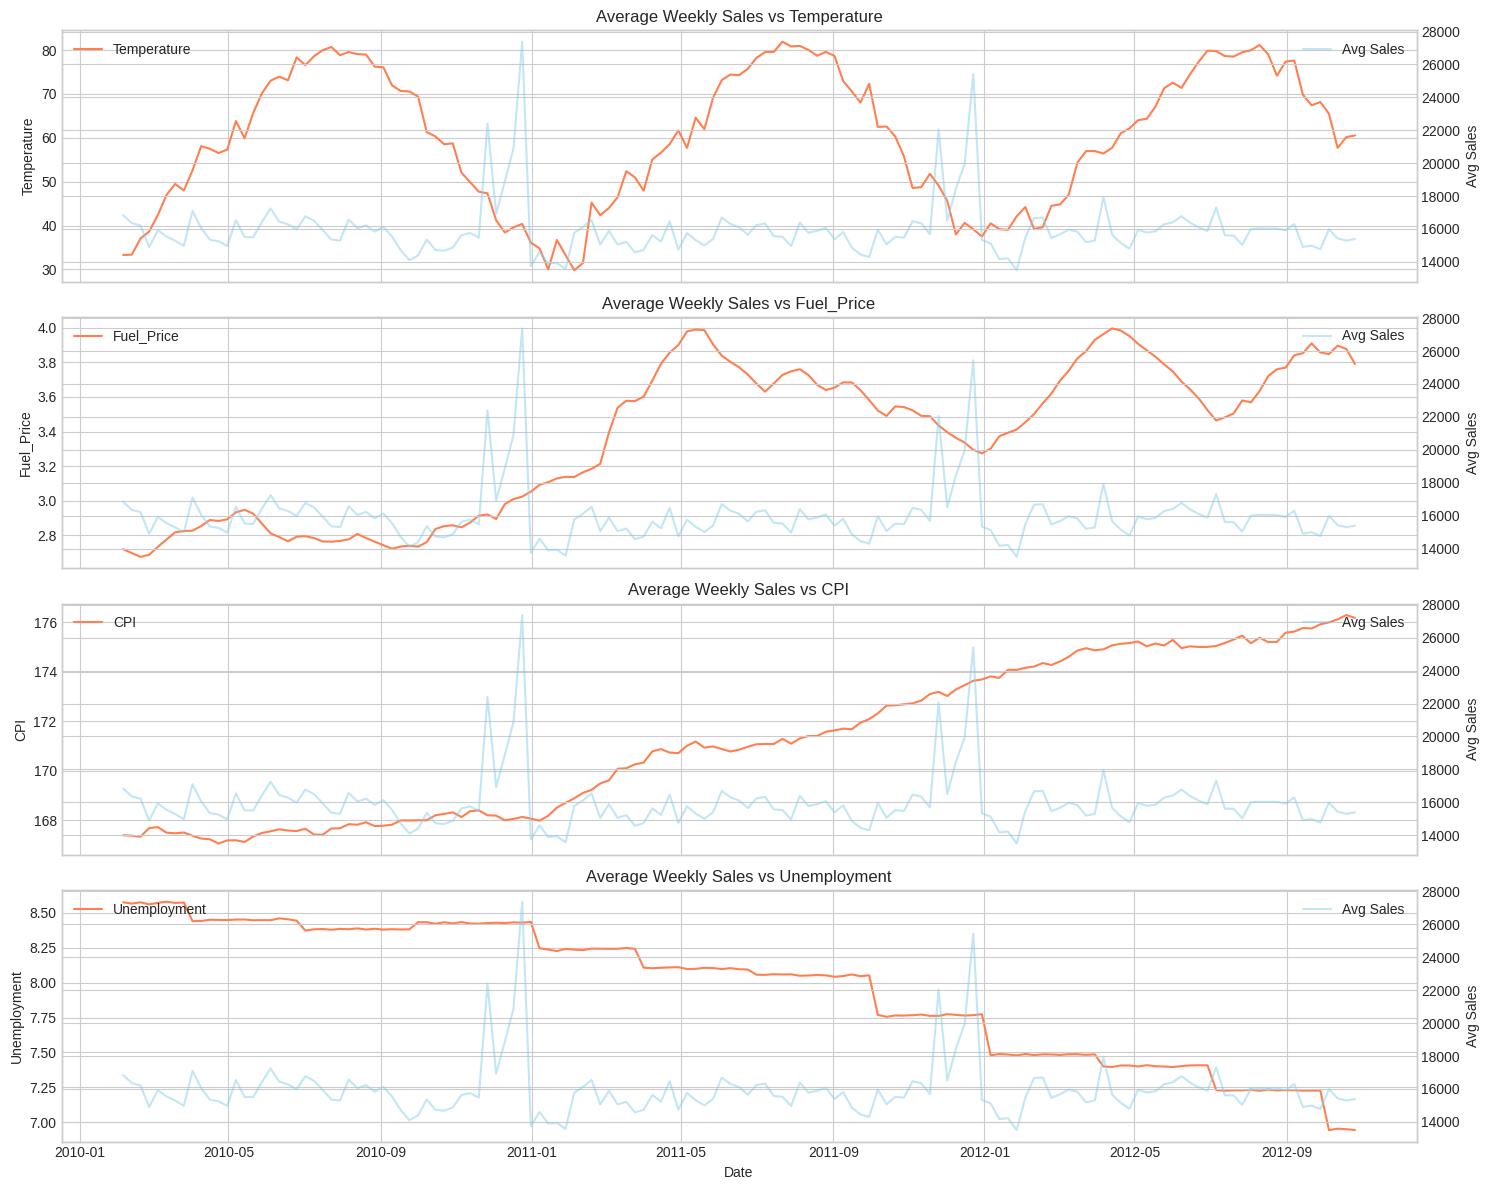

In [9]:
features_to_plot = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
df_agg = df_train.groupby('Date')[features_to_plot + ['Weekly_Sales']].mean().reset_index()

fig, axs = plt.subplots(len(features_to_plot), 1, figsize=(15, 12), sharex=True)

for i, feature in enumerate(features_to_plot):
    ax2 = axs[i].twinx()
    sns.lineplot(data=df_agg, x='Date', y=feature, ax=axs[i], color='coral', label=feature)
    sns.lineplot(data=df_agg, x='Date', y='Weekly_Sales', ax=ax2, color='skyblue', alpha=0.5, label='Avg Sales')
    axs[i].set_title(f'Average Weekly Sales vs {feature}', fontsize=12)
    axs[i].set_ylabel(feature)
    ax2.set_ylabel('Avg Sales')
    axs[i].legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()

### დასკვნა:
- **Temperature:** ტემპერატურასა და გაყიდვებს შორის აშკარა საპირისპირო სეზონური კავშირი ჩანს - როცა ტემპერატურა იკლებს (ზამთარი), გაყიდვები იმატებს (სადღესასწაულო სეზონი) და პირიქით. ეს შეიძლება იყოს სეზონურობის ეფექტი და არა პირდაპირი მიზეზ-შედეგობრივი კავშირი, მაგრამ მაინც სასარგებლო ფიჩერია.
- **Fuel Price:** საწვავის ფასი იზრდება დროთა განმავლობაში, მაგრამ გაყიდვებზე პირდაპირი, მკაფიო გავლენა არ ჩანს.
- **CPI (Consumer Price Index):** CPI-ს და გაყიდვებს შორის შესაძლოა სუსტი დადებითი კორელაცია იყოს.
- **Unemployment:** უმუშევრობის დონე, როგორც ჩანს, მცირედით კლებულობს დროთა განმავლობაში, მაგრამ გაყიდვებთან აშკარა კავშირი არ იკვეთება ამ გრაფიკიდან.

**მოდელირების იმპლიკაცია:** ოთხივე ფიჩერი უნდა ჩაირთოს მოდელში. Tree-based მოდელები (როგორიცაა LightGBM/XGBoost) თავად შეაფასებენ მათ მნიშვნელოვნებას.

### 2.5. Time Series Decomposition (Autocorrelation)
ავტოკორელაციის (ACF) და ნაწილობრივი ავტოკორელაციის (PACF) ფუნქციების ანალიზი გვეხმარება დროითი რიგის შიდა სტრუქტურის გაგებაში - მაგალითად, რომელი წინა პერიოდების მონაცემები (lags) ახდენს გავლენას მიმდინარე მნიშვნელობაზე. ეს კრიტიკულია Lag Features-ის შესაქმნელად.

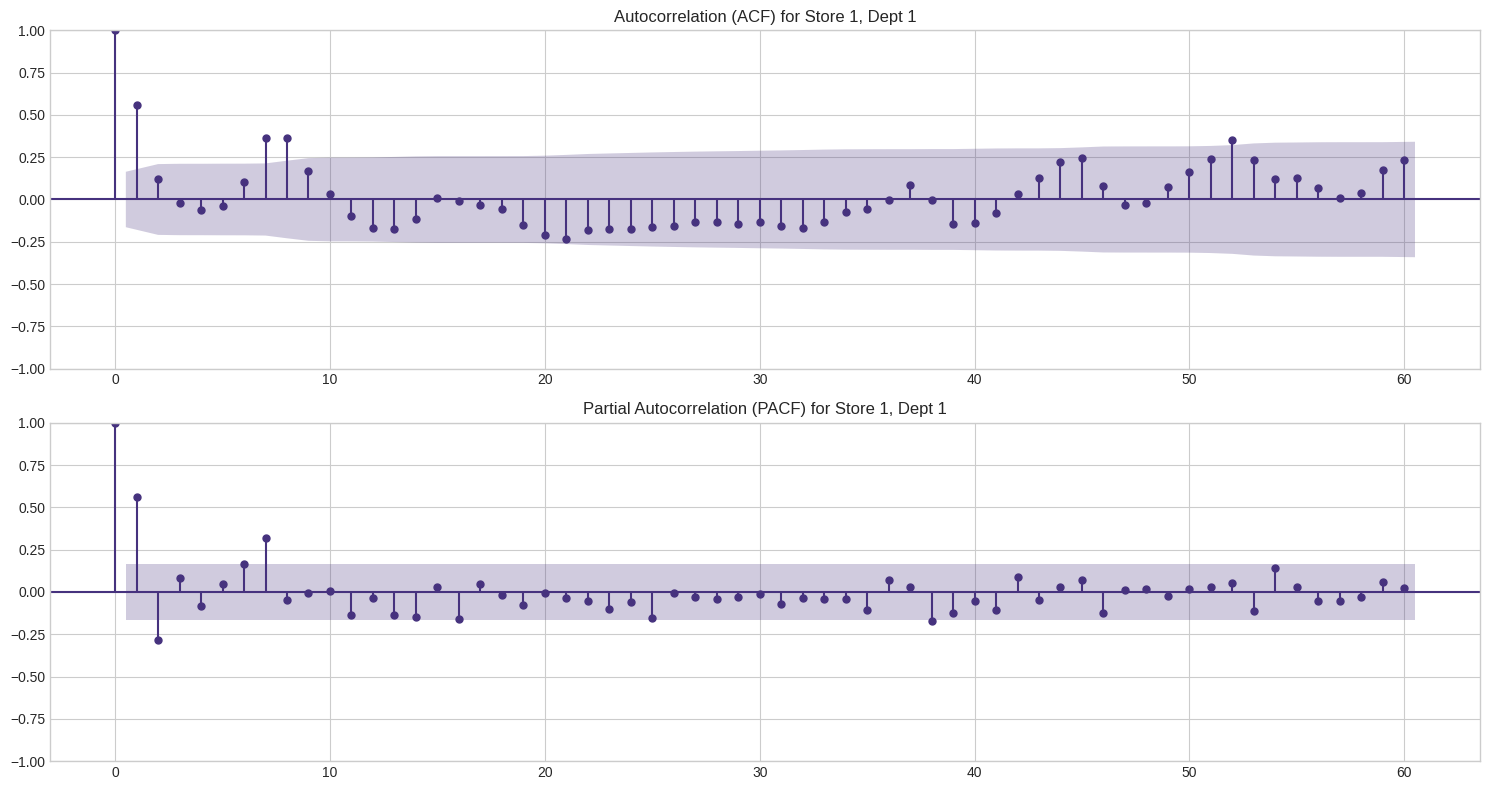

In [10]:
# Let's pick a specific time series: Store 1, Dept 1
ts_sample = df_train[(df_train['Store'] == 1) & (df_train['Dept'] == 1)].set_index('Date')['Weekly_Sales'].sort_index()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

plot_acf(ts_sample, lags=60, ax=ax1)
ax1.set_title('Autocorrelation (ACF) for Store 1, Dept 1')

plot_pacf(ts_sample, lags=60, ax=ax2)
ax2.set_title('Partial Autocorrelation (PACF) for Store 1, Dept 1')

plt.tight_layout()
plt.show()

### დასკვნა:
- **ACF:** ავტოკორელაციის გრაფიკზე ვხედავთ მნიშვნელოვან პიკს **Lag 52**-ზე. ეს არის ძალიან ძლიერი სიგნალი **წლიური სეზონურობის** შესახებ. ეს ნიშნავს, რომ მიმდინარე კვირის გაყიდვები ძლიერ კორელაციაშია 52 კვირის (1 წლის) წინანდელ გაყიდვებთან.
- **PACF:** ნაწილობრივი ავტოკორელაციის გრაფიკი აჩვენებს მნიშვნელოვან კორელაციას პირველ რამდენიმე lag-ზე (1, 2, 3), რაც იმაზე მიუთითებს, რომ წინა რამდენიმე კვირის გაყიდვები პირდაპირ გავლენას ახდენს მიმდინარე კვირაზე.

**მოდელირების იმპლიკაცია:** ეს ანალიზი პირდაპირ გვეუბნება, რომ Feature Engineering-ისას უნდა შევქმნათ:
1.  **Short-term lags:** `lag_1`, `lag_2`, `lag_3`, ...
2.  **Seasonal lags:** `lag_52`.

## 3. Key Takeaways & Feature Engineering Strategy

EDA-ს საფუძველზე, ჩამოვაყალიბოთ სტრატეგია, თუ რა ფიჩერები უნდა შევქმნათ ჩვენი მოდელებისთვის:

1.  **Date-Based Features:**
    *   `Year`, `Month`, `WeekOfYear`, `DayOfWeek`. ესენი დაგვეხმარება სეზონურობისა და ტრენდის დაჭერაში.

2.  **Lag Features (დაყოვნების ფიჩერები):**
    *   ACF/PACF ანალიზის მიხედვით, კრიტიკულია `Weekly_Sales`-ის წინა მნიშვნელობების გამოყენება.
    *   **Short-term:** `lag_1`, `lag_2`, `lag_3`, `lag_4`.
    *   **Seasonal:** `lag_51`, `lag_52`, `lag_53` (ერთი წლის წინანდელი კვირა და მისი მეზობლები).

3.  **Rolling Window Features (მოძრავი ფანჯრის ფიჩერები):**
    *   ბოლო 4, 8, 12 კვირის საშუალო, მედიანური, მინიმალური, მაქსიმალური გაყიდვები. ეს დაგვეხმარება ლოკალური ტრენდების დაჭერაში.
    *   `rolling(window=4).mean()`, `rolling(window=52).mean()`.

4.  **Holiday Features:**
    *   უბრალო `IsHoliday` ფიჩერის ნაცვლად, შევქმნათ კატეგორიული ფიჩერი დღესასწაულის სახელით: (`SuperBowl`, `LaborDay`, `Thanksgiving`, `Christmas`).
    *   დავამატოთ ბინარული ფიჩერები: `is_pre_holiday_week`, `is_post_holiday_week`.

5.  **Categorical Feature Encoding:**
    *   `Store`, `Dept`, და `Type` უნდა იყოს კატეგორიულ ცვლადებად. Tree-based მოდელები ამას კარგად ამუშავებენ, ხოლო ნეირონული ქსელებისთვის შეიძლება დაგვჭირდეს `Embedding` ფენების გამოყენება.

6.  **Interaction Features:**
    *   შესაძლოა, სასარგებლო იყოს ისეთი კომბინირებული ფიჩერების შექმნა, როგორიცაა `Store_Dept` (მაღაზიისა და დეპარტამენტის კომბინაცია), რადგან მათი ურთიერთქმედება შეიძლება მნიშვნელოვანი იყოს.

**შემდეგი ნაბიჯი:** ამ იდეებზე დაყრდნობით შევქმნათ მძლავრი `preprocessing` და `feature engineering` pipeline-ი, რომელსაც გამოვიყენებთ სხვადასხვა მოდელის გაწვრთნისას.